In [24]:
!wget https://github.com/andrew-veriga/DL/raw/master/assign.zip
!unzip -u assign.zip 
!rm assign.zip 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env



def argmax(q_values):
    top_value = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
            continue
        if q_values[i] == top_value:
            ties.append(i)
    return np.random.choice(ties)


test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8

np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0



test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8

np.random.seed(5)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

assert counts[0] != 100

assert counts[3] != 100

--2022-10-01 19:06:40--  https://github.com/andrew-veriga/DL/raw/master/assign.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip [following]
--2022-10-01 19:06:41--  https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6294 (6.1K) [application/zip]
Saving to: ‘assign.zip’

assign.zip          100%[===================>]   6.15K  --.-KB/s    in 0s      

2022-10-01 19:06:41 (72.6 MB/s) - ‘assign.zip’ saved [6294/6294]

Archive:  assign.zip


100%|██████████| 200/200 [00:08<00:00, 24.18it/s]


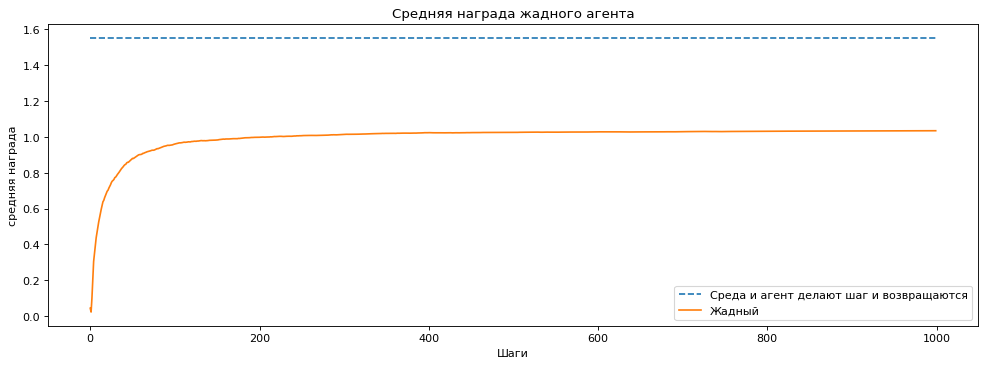

In [22]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        current_action = argmax(self.q_values)
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (1/self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])
        self.last_action = current_action

        return current_action



greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

action = greedy_agent.agent_step(reward=1, observation=0)

assert action == 2

assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]




num_runs = 200
num_steps = 1000
env = ten_arm_env.Environment
agent = GreedyAgent
agent_info = {"num_actions": 10}
env_info = {}

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):
    np.random.seed(run)

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    average_best += np.max(rl_glue.environment.arms)

    scores = [0]
    averages = []

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Среда и агент делают шаг и возвращаются", "Жадный"])
plt.title("Средняя награда жадного агента")
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

--2022-10-01 18:55:32--  https://github.com/andrew-veriga/DL/raw/master/assign.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip [following]
--2022-10-01 18:55:33--  https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6294 (6.1K) [application/zip]
Saving to: ‘assign.zip’

assign.zip          100%[===================>]   6.15K  --.-KB/s    in 0s      

2022-10-01 18:55:33 (89.7 MB/s) - ‘assign.zip’ saved [6294/6294]

Archive:  assign.zip


100%|██████████| 200/200 [00:02<00:00, 90.65it/s]


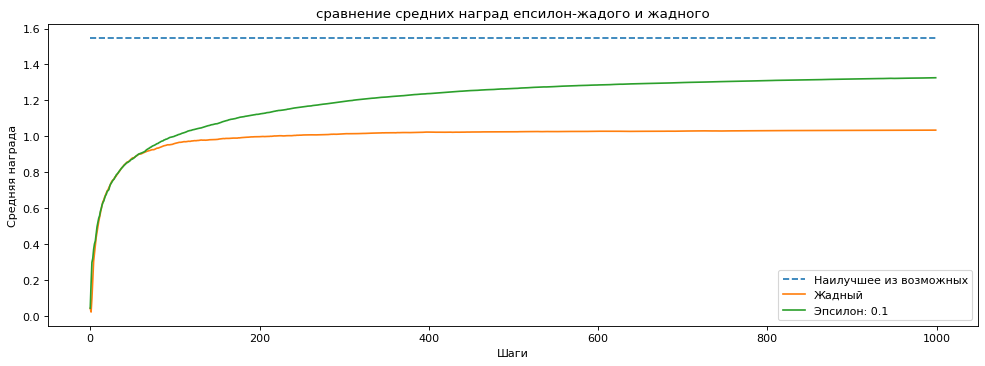

In [23]:
!wget https://github.com/andrew-veriga/DL/raw/master/assign.zip
!unzip -u assign.zip 
!rm assign.zip 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env



class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):

        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (1/self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])

        if np.random.random() < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = np.argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action



np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

assert action == 4, "E"



np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]



num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("сравнение средних наград епсилон-жадого и жадного")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Наилучшее из возможных", "Жадный", "Эпсилон: 0.1"))
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

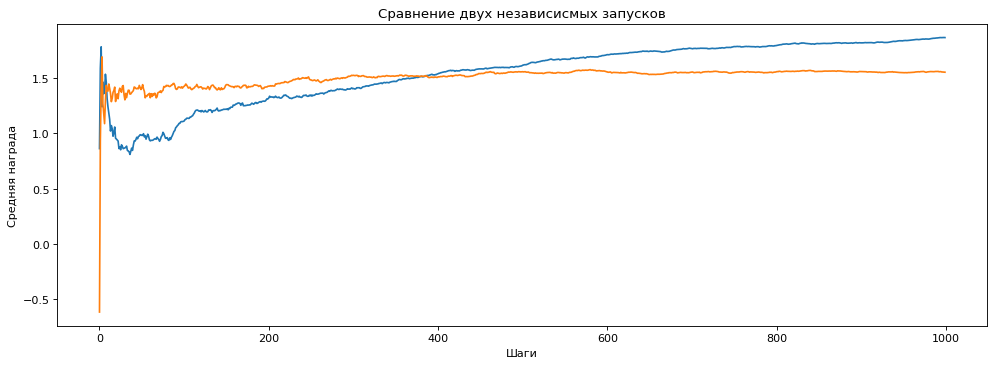

In [ ]:
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run)
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Сравнение двух независисмых запусков")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

In [ ]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")

Random Seed 1
Разведка
Разведка
Разведка


Random Seed 2
Разведка


100%|██████████| 200/200 [00:02<00:00, 69.92it/s]


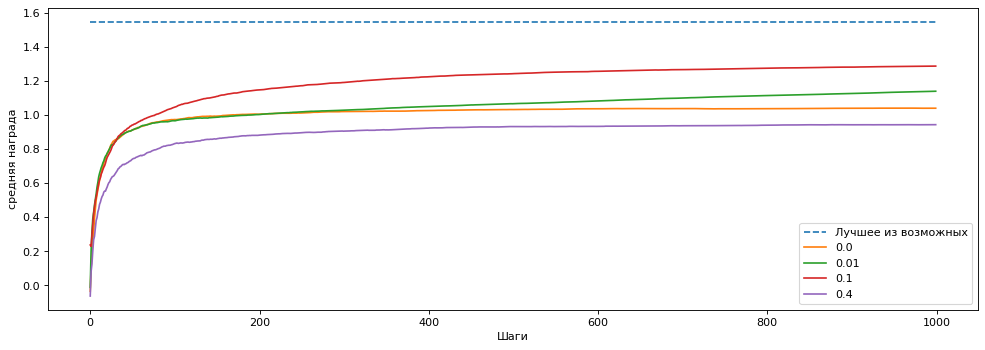

In [ ]:
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Лучшее из возможных"] + epsilons)
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()

100%|██████████| 200/200 [00:02<00:00, 96.17it/s]


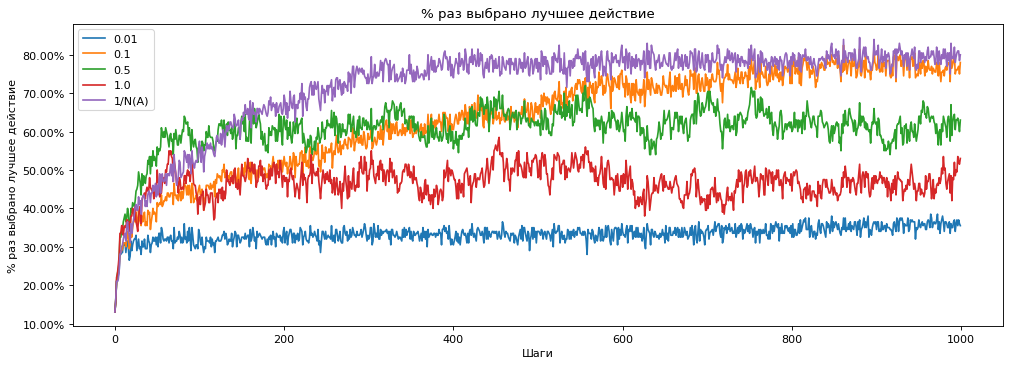

In [ ]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):

        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])

        if np.random.random() < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = np.argmax(self.q_values)

        self.last_action = current_action
        
        return current_action



for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]



np.random.seed(0)
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    
    action = e_greedy_agent.agent_step(1, 0)
    
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]



step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% раз выбрано лучшее действие")
plt.xlabel("Шаги")
plt.ylabel("% раз выбрано лучшее действие")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

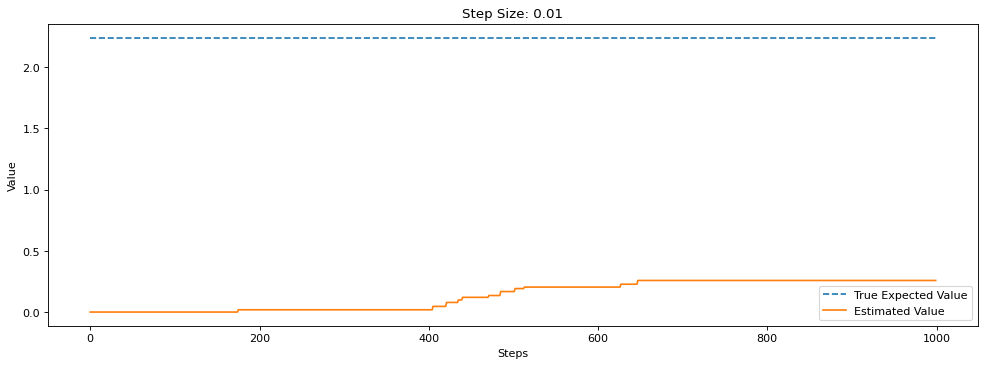

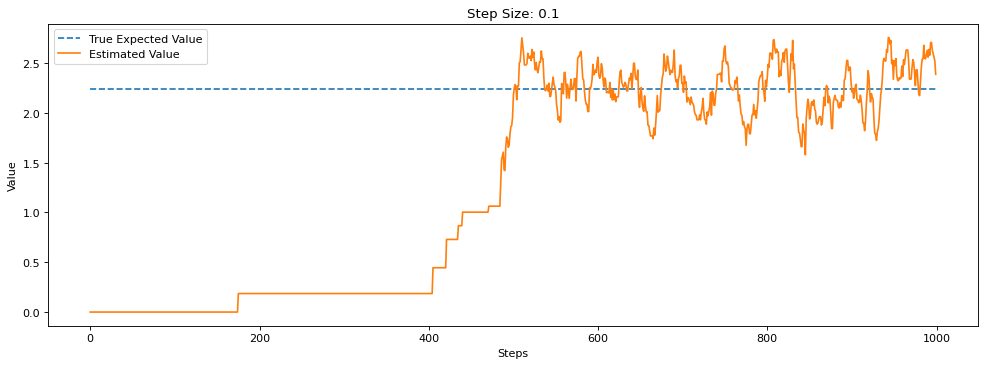

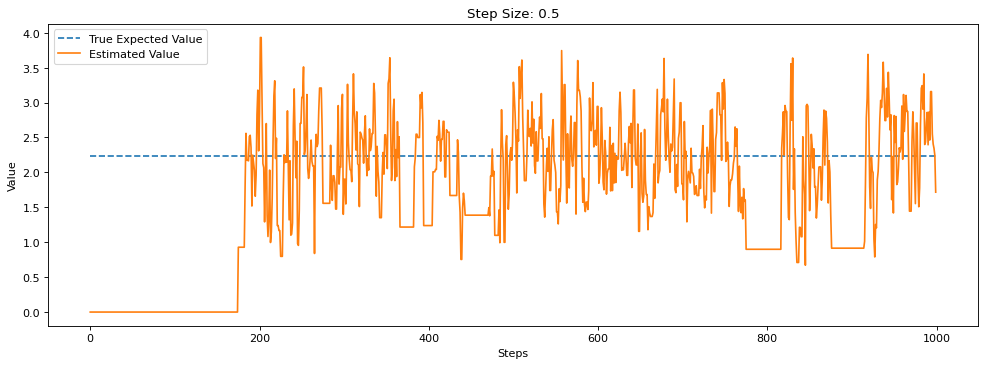

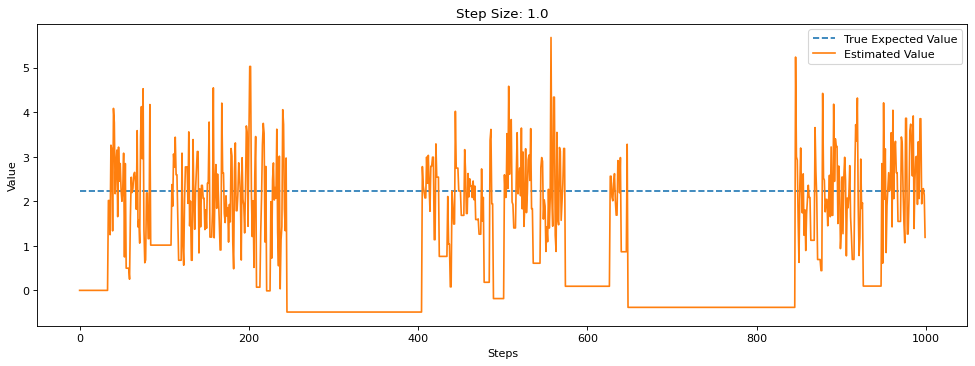

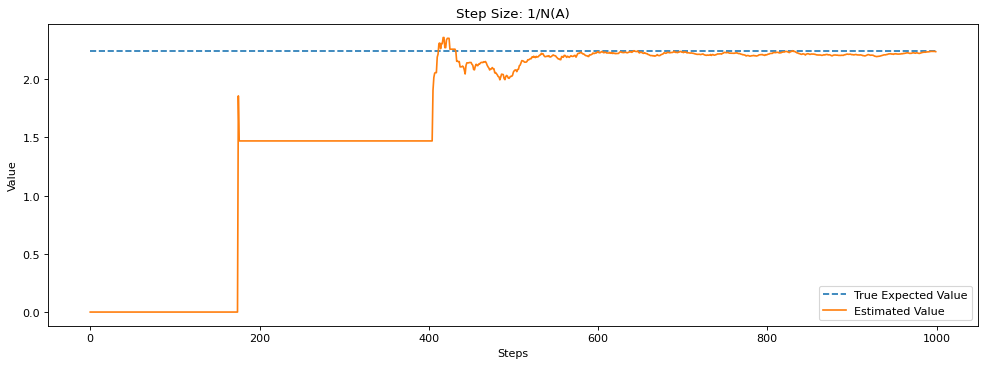

100%|██████████| 200/200 [00:04<00:00, 46.04it/s]


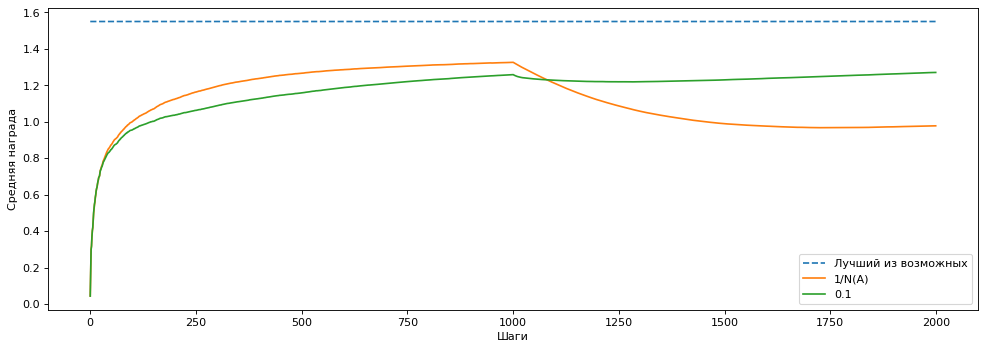

In [ ]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()




epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Лучший из возможных", "1/N(A)", "0.1"])
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()